# Анализ бизнес-показателей

В нашем распоряжении три датасета. Visits хранит лог сервера с информацией о посещениях сайта,orders — информацию о заказах, а costs.csv — информацию о расходах на рекламу.

Известно, что развлекательное приложение Procrastinate Pro+ ,несмотря на огромные вложения в рекламу, последние несколько месяцев компания терпит убытки.

Наша задача — разобраться в причинах и помочь компании выйти в плюс.

**Описание данных:**

Структура visits_info_short.csv:
* User Id — уникальный идентификатор пользователя,
* Region — страна пользователя,
* Device — тип устройства пользователя,
* Channel — идентификатор источника перехода,
* Session Start — дата и время начала сессии,
* Session End — дата и время окончания сессии.

Структура orders_info_short.csv:
* User Id — уникальный идентификатор пользователя,
* Event Dt — дата и время покупки,
* Revenue — сумма заказа.

Структура costs_info_short.csv:
* dt — дата проведения рекламной кампании,
* Channel — идентификатор рекламного источника,
* costs — расходы на эту кампанию.


## Загрузка данных и подготовка их к анализу

### Загрузка и перевод данных в нужный формат

In [221]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from datetime import datetime, timedelta

In [222]:
try:
    visits = pd.read_csv('/datasets/visits.csv').copy()
except:
    visits = pd.read_csv('C:/Users/jerno/PycharmProjects/sds2/Data/visits_info_short.csv').copy()
try:
    orders = pd.read_csv('/datasets/orders.csv').copy()
except:
    orders = pd.read_csv('C:/Users/jerno/PycharmProjects/sds2/Data/orders_info_short.csv').copy()
try:
    costs = pd.read_csv('/datasets/costs.csv').copy()
except:
    costs = pd.read_csv('C:/Users/jerno/PycharmProjects/sds2/Data/costs_info_short.csv').copy()

In [223]:
visits.columns=['user_id','region','device','channel','session_start','session_end']
visits['session_start']=pd.to_datetime(visits['session_start'])
visits['session_end']=pd.to_datetime(visits['session_end'])

In [224]:
orders.columns=['user_id','event_dt','revenue']
orders['event_dt']=pd.to_datetime(orders['event_dt'])

In [225]:
costs.columns=costs.columns.str.lower()
costs['dt']=pd.to_datetime(costs['dt'])

### Заполнение пропусков в данных

In [226]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   user_id        309901 non-null  int64         
 1   region         309901 non-null  object        
 2   device         309901 non-null  object        
 3   channel        309901 non-null  object        
 4   session_start  309901 non-null  datetime64[ns]
 5   session_end    309901 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(1), object(3)
memory usage: 14.2+ MB


In [227]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   40212 non-null  int64         
 1   event_dt  40212 non-null  datetime64[ns]
 2   revenue   40212 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 942.6 KB


In [228]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   dt       1800 non-null   datetime64[ns]
 1   channel  1800 non-null   object        
 2   costs    1800 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 42.3+ KB


**Как видим, пропусков не наблюдается**

### Удаление дубликатов в данных

In [229]:
visits.duplicated().sum()

0

In [230]:
orders.duplicated().sum()

0

In [231]:
costs.duplicated().sum()

0

**Дубликаты не наблюдаются**

##  Функции для расчёта и анализа LTV, ROI, удержания и конверсии.

 Функции для вычисления значений метрик:

- `get_profiles()` — для создания профилей пользователей,
- `get_retention()` — для подсчёта Retention Rate,
- `get_conversion()` — для подсчёта конверсии,
- `get_ltv()` — для подсчёта LTV.

Функции для построения графиков:

- `filter_data()` — для сглаживания данных,
- `plot_retention()` — для построения графика Retention Rate,
- `plot_conversion()` — для построения графика конверсии,
- `plot_ltv_roi` — для визуализации LTV и ROI.

### Функции для вычисления значений метрик

#### Профиль пользователей(get_profiles())

In [232]:
# функция для создания пользовательских профилей

def get_profiles(visits, orders, ad_costs):

    # находим параметры первых посещений
    profiles = (
        visits.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )

    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['dt'] = pd.to_datetime(profiles['dt'], format="%Y-%m-%d")
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())


    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )

    # объединяем траты на рекламу и число привлечённых пользователей
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    # результаты сохраним в столбец acquisition_cost (CAC)
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    # добавляем стоимость привлечения в профили
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # стоимость привлечения органических пользователей равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles
 

In [233]:
profiles=get_profiles(visits, orders, costs)

#### Retention rate(get_retention())

In [234]:
def get_retention(
    profiles, visits, observation_date, horizon_days, ignore_horizon=False
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        visits[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # рассчитываем удержание
    result_grouped = result_raw.pivot_table(
        index=['dt'], columns='lifetime', values='user_id', aggfunc='nunique'
    )
    cohort_sizes = (
        result_raw.groupby('dt')
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'cohort_size'})
    )
    result_grouped = cohort_sizes.merge(
        result_grouped, on='dt', how='left'
    ).fillna(0)
    result_grouped = result_grouped.div(result_grouped['cohort_size'], axis=0)

    # исключаем все лайфтаймы, превышающие горизонт анализа
    result_grouped = result_grouped[
        ['cohort_size'] + list(range(horizon_days))
    ]

    # восстанавливаем столбец с размерами когорт
    result_grouped['cohort_size'] = cohort_sizes

    # возвращаем таблицу удержания и сырые данные
    # сырые данные пригодятся, если нужно будет отыскать ошибку в расчётах
    return result_raw, result_grouped

####  Конверсия(get_conversion())

In [235]:
def get_conversion(
    profiles,
    visits,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        visits.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу конверсии
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        # считаем сумму с накоплением для каждой строки
        result = result.fillna(0).cumsum(axis = 1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # добавляем размеры когорт в таблицу конверсии
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 

In [236]:
conversion_raw, conversion, conversion_history = get_conversion(
    profiles, orders, datetime(2019, 11, 1).date(), 14
)
conversion

,cohort_size,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0
cohort,,,,,,,,,,,,,,,
All users,142620,0.04092,0.046705,0.049516,0.051522,0.052973,0.053898,0.054677,0.055392,0.055946,0.056458,0.056738,0.056977,0.057145,0.057369


####  LTV(get_ltv())

In [237]:
def get_ltv(
    profiles,  # Шаг 1. Получить профили и данные о покупках
    visits,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # Шаг 2. Добавить данные о покупках в профили

    result_raw = result_raw.merge(
        # добавляем в профили время совершения покупок и выручку
        visits[['user_id', 'event_dt', 'revenue']],
        on='user_id',
        how='left',
    )

    # Шаг 3. Рассчитать лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):

        # Шаг 4. Построить таблицу выручки
        # строим «треугольную» таблицу
        result = df.pivot_table(
            index=dims,
            columns='lifetime',
            values='revenue',  # в ячейках — выручка за каждый лайфтайм
            aggfunc='sum',
        )

        # Шаг 5. Посчитать сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)

        # Шаг 6. Вычислить размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )

        # Шаг 7. Объединить размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)

        # Шаг 8. Посчитать LTV
        # делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу LTV
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики LTV убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []
    # получаем таблицу динамики LTV
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы LTV и сырые данные
    return result_raw, result_grouped, result_in_time

In [238]:
ltv_raw, ltv, ltv_history = get_ltv(
    profiles, orders, datetime(2019, 11, 1).date(), 14
)
ltv

,cohort_size,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0
cohort,,,,,,,,,,,,,,,
All users,142620,0.241267,0.310905,0.364073,0.408661,0.447512,0.481909,0.513263,0.541481,0.569211,0.594565,0.617813,0.639767,0.661289,0.680757


### Функции для построения графиков

#### Cглаживание данных(filter_data())

In [239]:
# функция для сглаживания датафрейма
def filter_data(df, window):
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df

####  График Retention Rate(plot_retention())

In [240]:
def plot_retention(
    profiles, visits, observation_date, horizon_days, ignore_horizon=False
):
    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        visits[['user_id', 'session_start']], on='user_id', how='left')
    
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # рассчитываем удержание
    result_grouped = result_raw.pivot_table(
        index=['dt'], columns='lifetime', values='user_id', aggfunc='nunique'
    )
    cohort_sizes = (
        result_raw.groupby('dt')
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'cohort_size'})
    )
    result_grouped = cohort_sizes.merge(
        result_grouped, on='dt', how='left'
    ).fillna(0)
    result_grouped = result_grouped.div(result_grouped['cohort_size'], axis=0)

    # исключаем все лайфтаймы, превышающие горизонт анализа
    result_grouped = result_grouped[
        ['cohort_size'] + list(range(horizon_days))
    ]

    # восстанавливаем столбец с размерами когорт
    result_grouped['cohort_size'] = cohort_sizes

    # возвращаем таблицу удержания и сырые данные
    return result_raw, result_grouped

# получаем сырые данные и готовую таблицу
# игнорируем горизонт анализа
retention_raw, retention = plot_retention(
    profiles, visits, datetime(2019, 11, 1).date(), 14, ignore_horizon=True
)

#### График конверсии(plot_conversion())

In [241]:
def plot_conversion(
    profiles,
    visits,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        orders.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

#### Визуализация LTV и ROI (plot_ltv_roi())

In [242]:
def plot_ltv_roi (
    profiles,  # Шаг 1. Получить профили и данные о покупках
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
  
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # Шаг 2. Добавить данные о покупках в профили

    result_raw = result_raw.merge(
        # добавляем в профили время совершения покупок и выручку
        purchases[['user_id', 'event_dt', 'revenue']],
        on='user_id',
        how='left',
    )

    # Шаг 3. Рассчитать лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):

        # Шаг 3. Построить таблицу выручки
        # строим «треугольную» таблицу
        result = df.pivot_table(
            index=dims,
            columns='lifetime',
            values='revenue',  # в ячейках — выручка за каждый лайфтайм
            aggfunc='sum',
        )

        # Шаг 4. Посчитать сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)

        # Шаг 5. Вычислить размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )

        # Шаг 6. Объединить размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)

        # Шаг 7. Посчитать LTV
        # делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes
        # сохраняем в датафрейм данные пользователей и значения CAC, 
        # добавив параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    )

## Исследовательский анализ данных
**Задачи:**
* 1.Составить профили пользователей. Определить минимальную и максимальную даты привлечения пользователей.
* 2.Выяснить, из каких стран пользователи приходят в приложение и на какую страну приходится больше всего платящих пользователей. Постройть таблицу, отражающую количество пользователей и долю платящих из каждой страны.
* 3.Узнайть, какими устройствами пользуются клиенты и какие устройства предпочитают платящие пользователи. Постройть таблицу, отражающую количество пользователей и долю платящих для каждого устройства.
* 4.Изучить рекламные источники привлечения и определите каналы, из которых пришло больше всего платящих пользователей. Постройть таблицу, отражающую количество пользователей и долю платящих для каждого канала привлечения.
* Вывод после каждой задачи

### Профили пользователей. Минимальная и максимальная даты привлечения пользователей.

In [243]:
profiles.head()

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-07 20:58:57,True,1.088172
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,2019-07-09 12:46:07,False,1.107237
2,6085896,2019-10-01 09:58:33,organic,iPhone,France,2019-10-01,2019-10-01 09:58:33,False,0.000000
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,2019-08-22 21:35:48,False,0.988235
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,2019-10-02 00:07:44,False,0.230769


In [244]:
profiles['dt'].min()

Timestamp('2019-05-01 00:00:00')

In [245]:
profiles['dt'].max()

Timestamp('2019-10-27 00:00:00')

**Вывод:**
* Минимальная дата привлечения: 2019-05-01
* Максимальная дата привлечения: 2019-10-27

###  Количество пользователей и долю платящих из каждой страны.

In [246]:
reg=profiles.groupby('region').agg({'payer':'sum','region':'count'})
reg['share,%']=(reg['payer']/reg['region'])*100
reg.sort_values(by='share,%',ascending=False)

,payer,region,"share,%"
region,,,
United States,6902,100002,6.901862
Germany,616,14981,4.111875
UK,700,17575,3.982930
France,663,17450,3.799427


**Вывод:**
* больше всего доля платящих пользователей в Соединённых Штатах : 6.9%
* больше всего количество пользователей в Соединённых Штатах : 100002

### Количество пользователей и долю платящих для каждого устройства

In [247]:
dev=profiles.groupby('device').agg({'payer':'sum','device':'count'})
dev['share,%']=(dev['payer']/dev['device'])*100
dev.sort_values(by='share,%',ascending=False)

,payer,device,"share,%"
device,,,
Mac,1912,30042,6.364423
iPhone,3382,54479,6.207897
Android,2050,35032,5.851793
PC,1537,30455,5.046790


**Вывод:**
* как видим, платящие клиенты предпочитают одни и те же девайсы: Android, Mac, PC, iPhone
* больше всего доля платящих клиентов у Mac

### Количество пользователей и долю платящих для каждого канала привлечения.

In [248]:
chan=profiles.groupby('channel').agg({'payer':'sum','channel':'count'})
chan['share,%']=(chan['payer']/chan['channel'])*100
chan.sort_values(by='share,%', ascending=False)

,payer,channel,"share,%"
channel,,,
FaceBoom,3557,29144,12.204914
AdNonSense,440,3880,11.340206
lambdaMediaAds,225,2149,10.469986
TipTop,1878,19561,9.600736
RocketSuperAds,352,4448,7.913669
WahooNetBanner,453,8553,5.296387
YRabbit,165,4312,3.826531
MediaTornado,156,4364,3.574702
LeapBob,262,8553,3.063253


**Вывод:**
* больше всего доли платящих клиентов у каналов:
   * FaceBoom: 12.2%
   * AdNonSense: 11.3%
   * lambdaMediaAds: 10.5%

## Маркетинг
**Задачи:**
* 1.Посчитать общую сумму расходов на маркетинг.
* 2.Выяснить, как траты распределены по рекламным источникам, то есть сколько денег потратили на каждый источник.
* 3.Постройть визуализацию динамики изменения расходов во времени (по неделям и месяцам) по каждому источнику.Отразить это на одном графике.
* 4.Узнать, сколько в среднем стоило привлечение одного пользователя (CAC) из каждого источника. Использовать  профили пользователей.
* Промежуточные выводы

### Общая сумма расходов на маркетинг

In [249]:
costs['costs'].sum()

105497.30000000002

**Вывод:**
* общая сумма, потраченная на рекламу: 105497$

### Распределение затрат по рекламным источникам

In [250]:
costs.groupby('channel').agg({'costs':'sum'}).sort_values(by='costs',ascending=False)

,costs
channel,
TipTop,54751.30
FaceBoom,32445.60
WahooNetBanner,5151.00
AdNonSense,3911.25
OppleCreativeMedia,2151.25
RocketSuperAds,1833.00
LeapBob,1797.60
lambdaMediaAds,1557.60
MediaTornado,954.48


**Вывод:**
* больше всего уходит затрат на рекламу у канала TipTop: 54751
* меньше всего уходит затрат на рекламу у канала YRabbit: 944

### Визуализация динамики изменения расходов во времени

In [251]:
costs['month']=pd.to_datetime(costs['dt']).dt.month
costs['week']=costs['dt'].dt.isocalendar().week

In [252]:
costs.pivot_table(index=['week','month'],values='costs',aggfunc='sum').sort_values(by='costs',ascending=False).head()

,,costs
week,month,
39,9,6784.580
43,10,5601.140
38,9,5473.535
40,10,5410.985
41,10,5190.355


<div class="alert alert-info">График трат в динамике по всем источникам</b> 

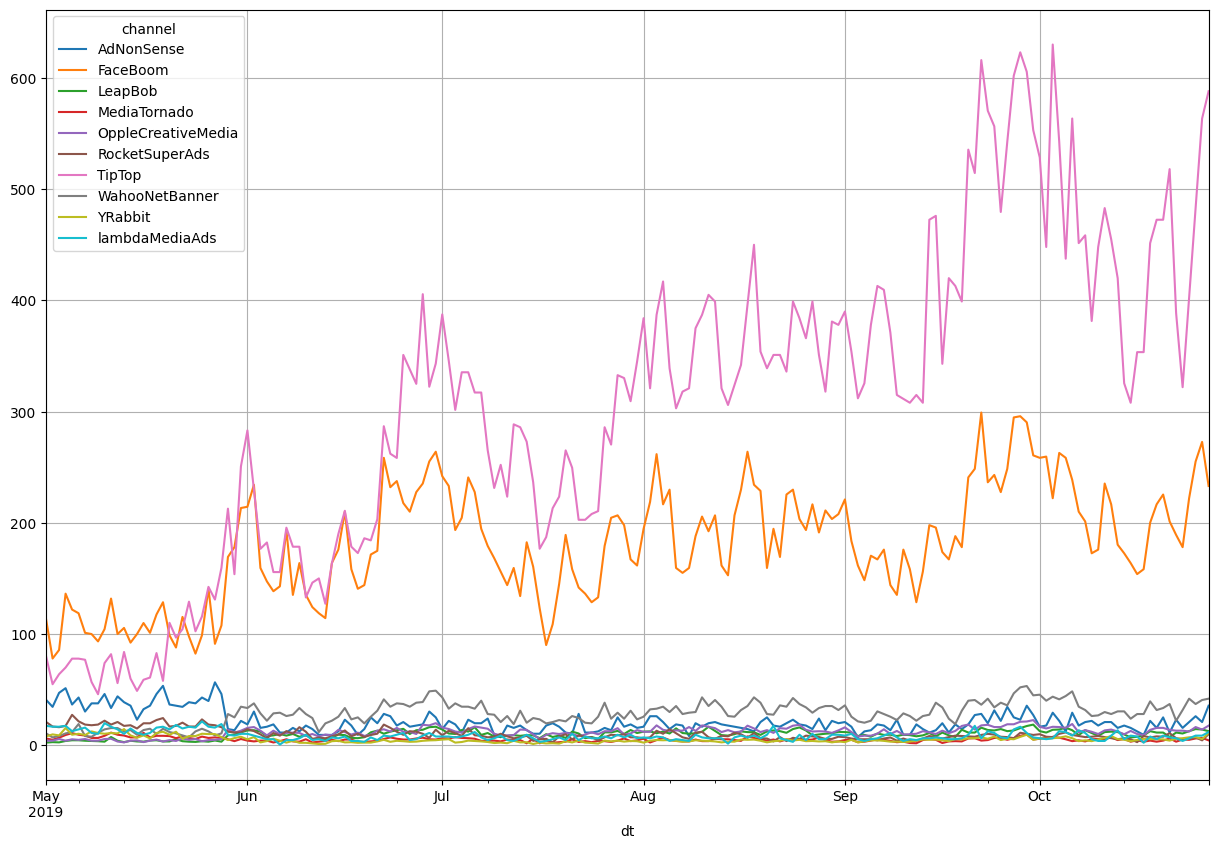

In [254]:
costs.pivot_table(index='dt',columns='channel',values='costs',aggfunc='sum').plot(grid=True, figsize=(15,10))
plt.show()

**Вывод:**
* наблюдаем возрастающую динамику трат у канала TipTop; этот канал имеет наибольшие траты на рекламу
* следующим каналам по количеству трат является FaceBoom; у данного канала затраты на протяжении рассматриваемого времени лежат в пределах от 100 до 300 
* у остальных каналов наблюдается относительно одна и та же динамика, но каналы AdNonSense, WahooNetBanner местами незначительно выбиваюстя из неё

###  Средняя цена  привлечения одного пользователя(CAC)  из каждого источника

<div class="alert alert-info">Все значения таблицы</b> 

In [256]:
cost_avg=profiles.query('channel!="organic"').groupby('channel')['acquisition_cost'].mean()
cost_avg.sort_values(ascending=False).to_frame()

,acquisition_cost
channel,
TipTop,2.799003
FaceBoom,1.113286
AdNonSense,1.008054
lambdaMediaAds,0.724802
WahooNetBanner,0.602245
RocketSuperAds,0.412095
OppleCreativeMedia,0.250000
YRabbit,0.218975
MediaTornado,0.218717


**Вывод:**
* самая большая средняя цена привлечения пользователя у канала TipTop: 2.8
* самая маленикая средняя цена привлечения пользователя у канала LeapBob: 0.21

## Оценка окупаемости рекламы

**Задача:**
* Используя графики LTV, ROI и CAC, проанализировать окупаемость рекламы. 

Считайть, что на календаре 1 ноября 2019 года, а в бизнес-плане заложено, что пользователи должны окупаться не позднее чем через две недели после привлечения. Необходимость включения в анализ органических пользователей определите самостоятельно.
* 1.Проанализируйте окупаемость рекламы c помощью графиков LTV и ROI, а также графики динамики LTV, CAC и ROI
* 2.Проверьте конверсию пользователей и динамику её изменения. То же самое сделайте с удержанием пользователей. Постройте и изучите графики конверсии и удержания.
* 3.Проанализируйте окупаемость рекламы с разбивкой по устройствам. Постройте графики LTV и ROI, а также графики динамики LTV, CAC и ROI.
* 4.Проанализируйте окупаемость рекламы с разбивкой по странам. Постройте графики LTV и ROI, а также графики динамики LTV, CAC и ROI
* 5.Проанализируйте окупаемость рекламы с разбивкой по рекламным каналам. Постройте графики LTV и ROI, а также графики динамики LTV, CAC и ROI.

**Ответить на вопросы:**
* 1. Окупается ли реклама, направленная на привлечение пользователей в целом?
* 2. Какие устройства, страны и рекламные каналы могут оказывать негативное влияние на окупаемость рекламы?
* 3. Чем могут быть вызваны проблемы окупаемости?


* Напиcать вывод, описать возможные причины обнаруженных проблем и промежуточные рекомендации для рекламного отдела.

### Анализ окупаемости рекламы

#### Графики динамики LTV, CAC, ROI;

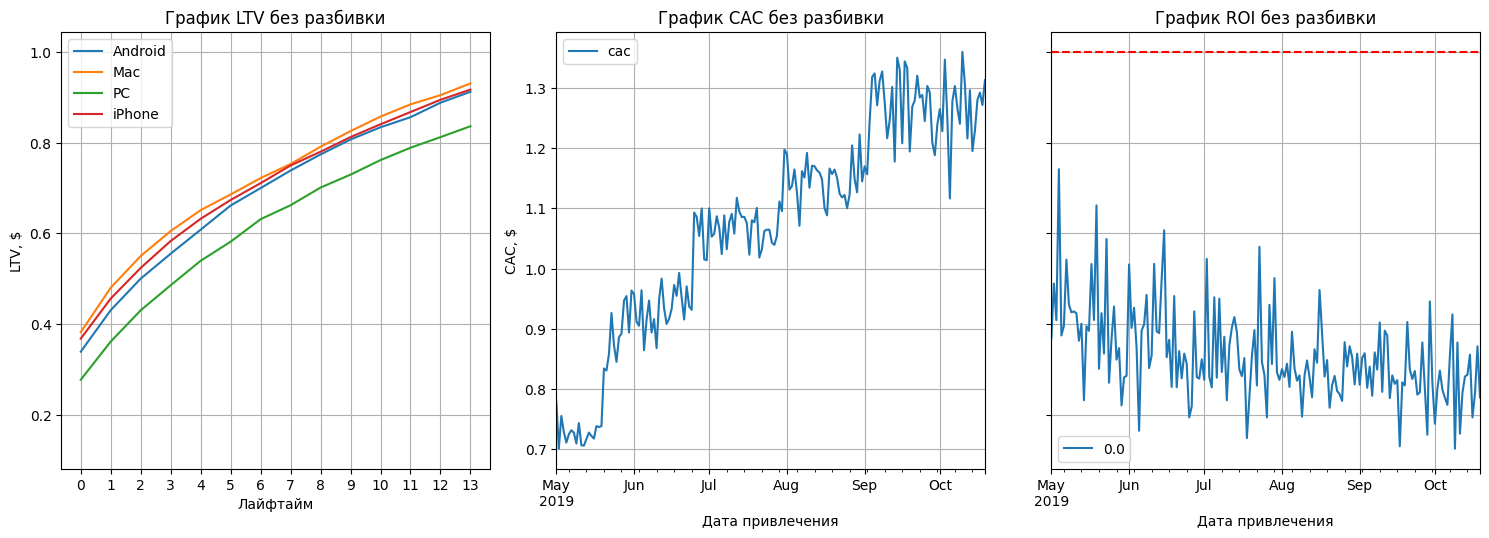

In [257]:
profiles = profiles.query('channel != "organic"')
ltv_raw, ltv, ltv_history, roi, roi_history = plot_ltv_roi(
    profiles, orders, datetime(2019, 11, 1).date(), 14, dimensions=['device']
)

plt.figure(figsize=(15, 10))
ax1=plt.subplot(2, 3, 1)
report = ltv.drop(columns=['cohort_size'])
report.T.plot(grid=True,  xticks=list(report.columns.values), ax=ax1)
plt.legend()
plt.title('График LTV без разбивки')
plt.ylabel('LTV, $')
plt.xlabel('Лайфтайм')


ax2=plt.subplot(2, 3, 2)
roi_history.pivot_table(
    index='dt', values='cac')\
.plot(grid=True, ax=ax2)
plt.ylabel('CAC, $')
plt.xlabel('Дата привлечения')
plt.title('График САС без разбивки')

ax3 = plt.subplot(2, 3, 3, sharey=ax1)
roi_history.pivot_table(
    index='dt', values=0)\
.plot(grid=True,ax=ax3)

plt.title('График ROI без разбивки')
plt.ylabel('ROI')
plt.xlabel('Дата привлечения')
plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')

plt.tight_layout()
plt.show() 


#### Промежуточный вывод:
* LTV: общий LTV увеличивается; то есть сумма денег, которую приносят пользователи в среднем, растёт
* CAC: общий СAC увеличивается; то есть сумма денег, которую компания тратит на рекламу дял всех пользователей, растёт
* ROI: окупаемость инвестиций не доходит до уровня окупаемости

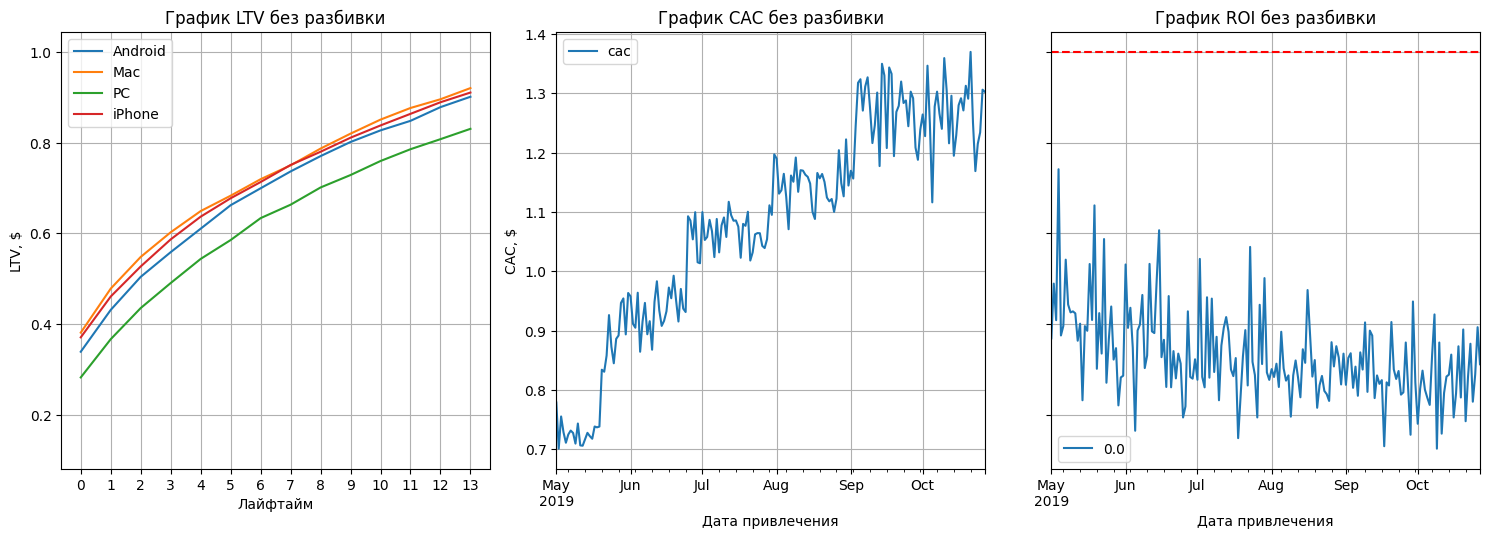

In [258]:
profiles = profiles.query('channel != "organic"')
ltv_raw, ltv, ltv_history, roi, roi_history = plot_ltv_roi(
    profiles, orders, datetime(2019, 11, 11).date(), 14, dimensions=['device']
)

plt.figure(figsize=(15, 10))
ax1=plt.subplot(2, 3, 1)
report = ltv.drop(columns=['cohort_size'])
report.T.plot(grid=True,  xticks=list(report.columns.values), ax=ax1)
plt.legend()
plt.title('График LTV без разбивки')
plt.ylabel('LTV, $')
plt.xlabel('Лайфтайм')


ax2=plt.subplot(2, 3, 2)
roi_history.pivot_table(
    index='dt', values='cac')\
.plot(grid=True, ax=ax2)
plt.ylabel('CAC, $')
plt.xlabel('Дата привлечения')
plt.title('График САС без разбивки')

ax3 = plt.subplot(2, 3, 3, sharey=ax1)
roi_history.pivot_table(
    index='dt', values=0)\
.plot(grid=True,ax=ax3)

plt.title('График ROI без разбивки')
plt.ylabel('ROI')
plt.xlabel('Дата привлечения')
plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')

plt.tight_layout()
plt.show() 


### Динамика изменения конверсии пользователя и удержания пользователя

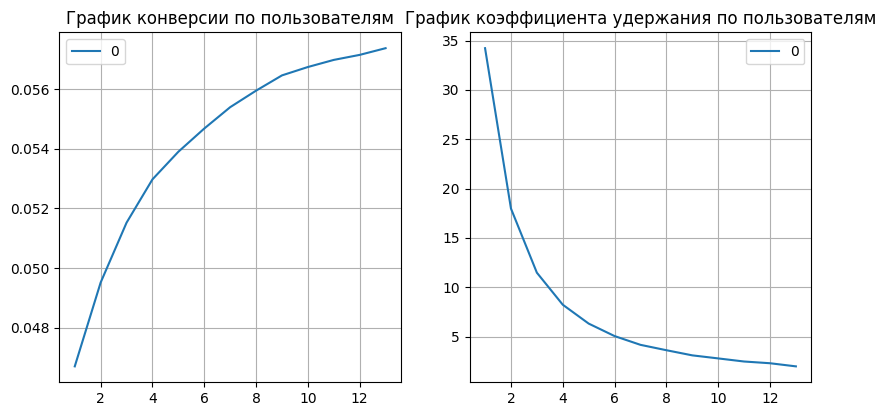

In [270]:
profiles = profiles.query('channel != "organic"')
plt.figure(figsize=(15, 10))
ax1=plt.subplot(2, 3, 1)
conversion.drop(columns=['cohort_size',0]).sum().to_frame().plot(grid=True, ax=ax1)
plt.title('График конверсии по пользователям')


ax2=plt.subplot(2, 3, 2)
retention.drop(columns=['cohort_size',0]).sum().to_frame().plot(grid=True, ax=ax2)
plt.title('График коэффициента удержания по пользователям')
plt.show()


#### Промежуточный вывод
* Conversion Rate: конверсия непрерывно растёт к 14 лайфтайму
* Retention Rate: коэффицинет непрерывно падает к 14 лайфтайму

### Анализ окупаемости рекламы с разбивкой по устройствам

#### Графики динамики LTV, CAC, ROI

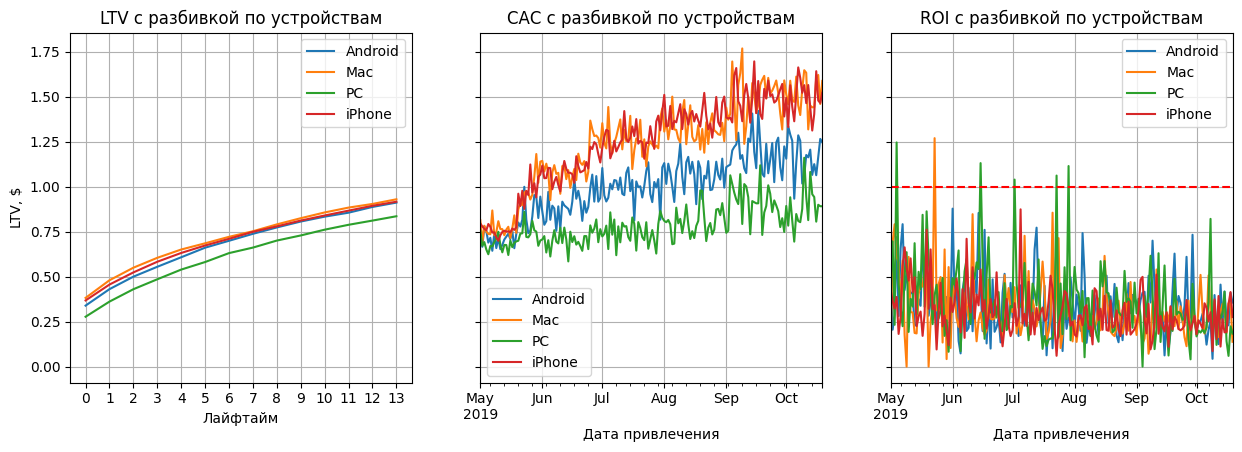

In [260]:
profiles = profiles.query('channel != "organic"')
ltv_raw, ltv, ltv_history, roi, roi_history = plot_ltv_roi(
    profiles, orders, datetime(2019, 11, 1).date(), 14, dimensions=['device']
)

plt.figure(figsize=(15, 10))

ax1=plt.subplot(2, 3, 1)
report = ltv.drop(columns=['cohort_size'])
report.T.plot(grid=True, xticks=list(report.columns.values),ax=ax1)
plt.title('LTV с разбивкой по устройствам')
plt.ylabel('LTV, $')
plt.xlabel('Лайфтайм')
plt.legend()

ax2=plt.subplot(2, 3, 2, sharey=ax1)
roi_history.pivot_table(
    index='dt', columns='device', values='cac', aggfunc='mean'
).plot(grid=True,ax=ax2)
plt.ylabel('CAC, $')
plt.xlabel('Дата привлечения')
plt.title('САС с разбивкой по устройствам')
plt.legend()


ax3=plt.subplot(2, 3, 3, sharey=ax1)
roi_history.pivot_table(
    index='dt', columns='device', values=0, aggfunc='mean'
).plot(grid=True,ax=ax3)
plt.legend()
plt.title('ROI с разбивкой по устройствам')
plt.ylabel('ROI')
plt.xlabel('Дата привлечения')
plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
plt.show()

#### Промежуточный вывод:
LTV:
* прибыль компании на протяжении всего лайфтайма меньше всего с PC(отличается на 0.25 от остальных)

CAC: 
* затраты на рекламу почти одинаковы у Mac и iPhone(не удивительно, ведь у них одна и та же компания)
* меньше всего затрат идёт на рекламу PC

ROI:
* уровень окупаемости пересекают только два устройства: Mac и PC 

### Анализ окупаемости рекламы с разбивкой по cтранам

####  Графики динамики LTV, CAC, ROI.

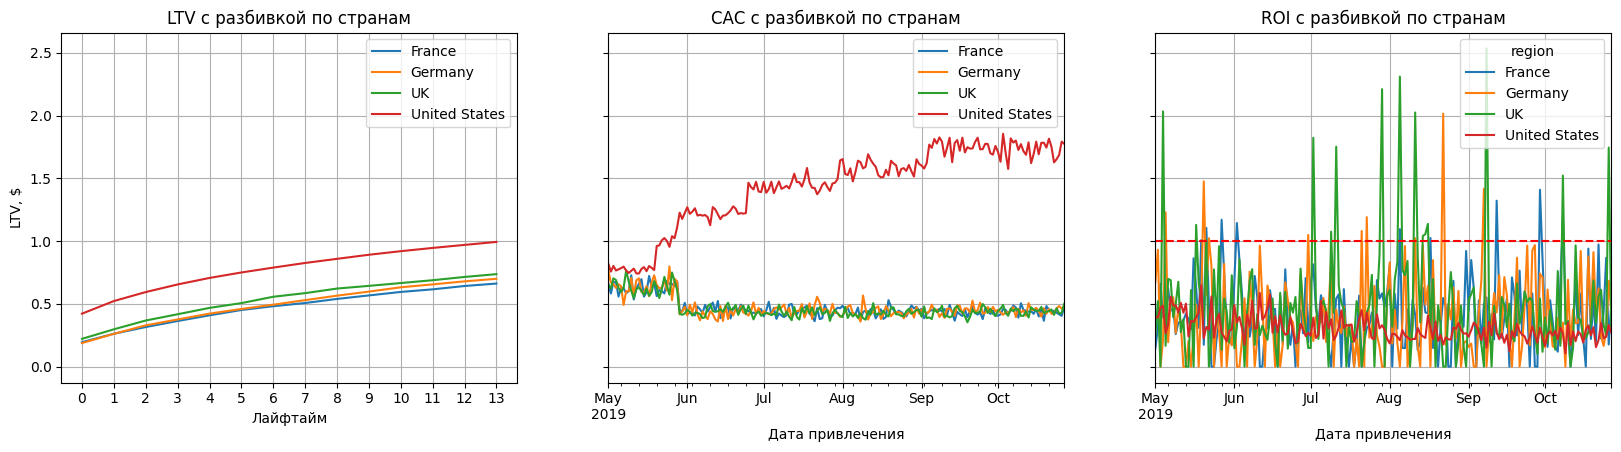

In [261]:
profiles = profiles.query('channel != "organic"')
ltv_raw, ltv, ltv_history, roi, roi_history = plot_ltv_roi(
    profiles, orders, datetime(2019, 11, 11).date(), 14, dimensions=['region']
)

plt.figure(figsize=(20, 10))

ax1=plt.subplot(2, 3, 1)
report = ltv.drop(columns=['cohort_size'])
report.T.plot(grid=True, xticks=list(report.columns.values),ax=ax1)
plt.legend()
plt.title('LTV с разбивкой по странам')
plt.ylabel('LTV, $')
plt.xlabel('Лайфтайм')


ax2=plt.subplot(2, 3, 2, sharey=ax1)
roi_history.pivot_table(
    index='dt', columns='region', values='cac', aggfunc='mean'
).plot(grid=True,ax=ax2)
plt.legend()
plt.ylabel('CAC, $')
plt.xlabel('Дата привлечения')
plt.title('САС с разбивкой по странам')


ax3=plt.subplot(2, 3, 3, sharey=ax1)
roi_history.pivot_table(
    index='dt', columns='region', values=0, aggfunc='mean'
).plot(grid=True, ax=ax3)
plt.title('ROI с разбивкой по странам')
plt.ylabel('ROI')
plt.xlabel('Дата привлечения')
plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
plt.show()


#### Промежуточный вывод:
LTV:
* прибыль с рекламы больше всего в США, отличается от других стран в 2 раза

CAC:
* заметим, что затраты на рекламу намного больше у США, чем у других стран
* затраты на рекламу в Германии, Франции, Великобритании идут в одних и тех же пределах; приближённо одинаковы

ROI:
* окупаемость с рекламы меньше всего в США
* окупаемость с рекламы больше всего в Великобритании( судим по скачкам ROI, также по количеству раз пересечения уровня окупаемости)

### Анализ окупаемости рекламы с разбивкой по рекламным каналам

#### Графики динамики LTV, CAC, ROI..

**LTV**

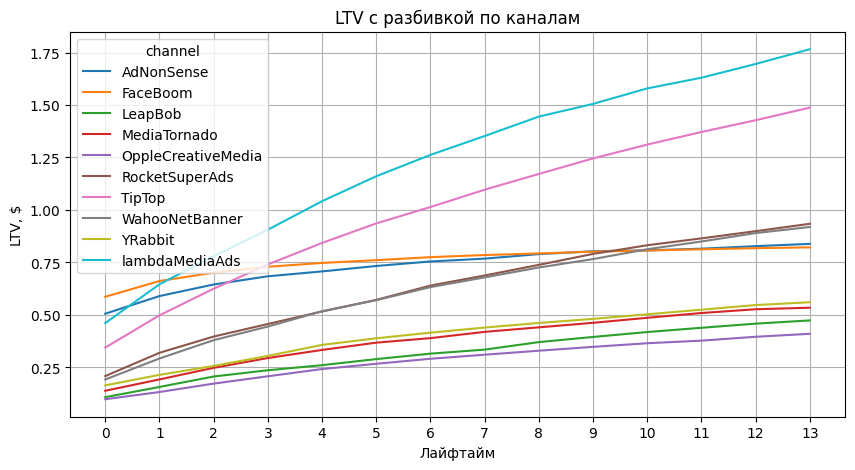

In [262]:
profiles = profiles.query('channel != "organic"')
ltv_raw, ltv, ltv_history = get_ltv(
    profiles, orders, datetime(2019, 11, 1).date(), 14, dimensions=['channel']
)
report = ltv.drop(columns=['cohort_size'])
report.T.plot(grid=True, figsize=(10, 5), xticks=list(report.columns.values))
plt.title('LTV с разбивкой по каналам')
plt.ylabel('LTV, $')
plt.xlabel('Лайфтайм')
plt.show()

**CAC**

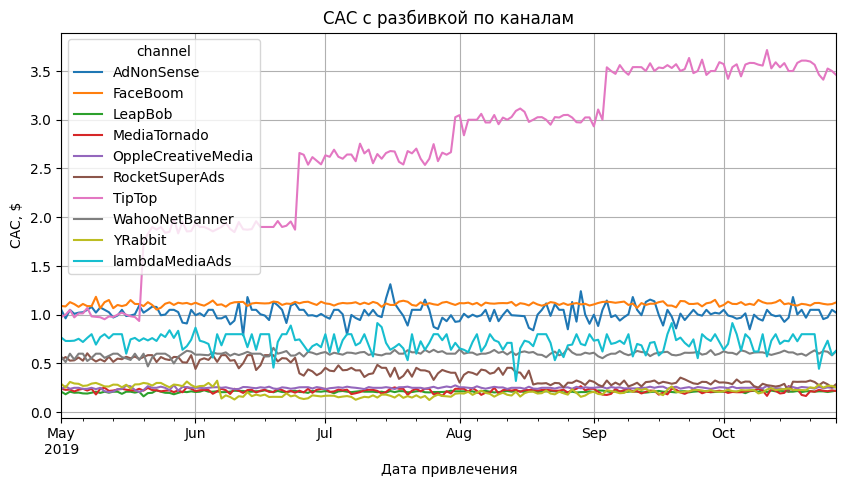

In [263]:
profiles = profiles.query('channel != "organic"')
ltv_raw, ltv, ltv_history, roi, roi_history = plot_ltv_roi(
    profiles, orders, datetime(2019, 11, 11).date(), 14, dimensions=['channel']
)


# строим график истории изменений CAC
roi_history.pivot_table(
    index='dt', columns='channel', values='cac', aggfunc='mean'
).plot(grid=True, figsize=(10, 5))

plt.ylabel('CAC, $')
plt.xlabel('Дата привлечения')
plt.title('САС с разбивкой по каналам')
plt.show()

**ROI**

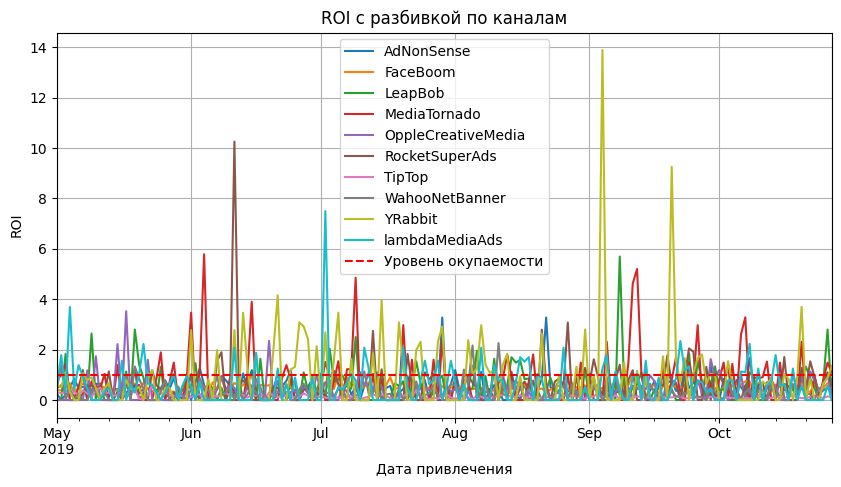

In [264]:
profiles = profiles.query('channel != "organic"')
roi_history.pivot_table(
    index='dt', columns='channel', values=0, aggfunc='mean'
).plot(grid=True, figsize=(10, 5))

plt.title('ROI с разбивкой по каналам')
plt.ylabel('ROI')
plt.xlabel('Дата привлечения')
plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
plt.legend()
plt.show()

#### Промежуточный вывод
LTV:
* прибыль с одного клиента у некоторых каналов заметно отличается друг от друга
* прибыль с одного клиента больше всего у канала lambdaMediaAds
* прибыль с одного клиента меньше всего у канала с "органическими" пользователями: organic

CAC:
* затраты на канал TipTop растёт каждый месяц скачкообразно; затраты заметно отличаются от других каналов
* затраты на каналы YRabbit, MediaTornado, LeapBob, OppleCreativeMedia меньше, чем на остальные; затраты на данные каналы идут в одних и тех же пределах

ROI:
* график возврата с инвестиций у канала YRabbit имеет большее количество "выходов" за линию окупаемости, также он имеет заметные скачки по сравнению с остальными каналами

#### Ответы на вопросы

* 1. Окупается ли реклама, направленная на привлечение пользователей в целом?
* 2. Какие устройства, страны и рекламные каналы могут оказывать негативное влияние на окупаемость рекламы?
* 3. Чем могут быть вызваны проблемы окупаемости?

1. Нет, реклама не окупается
* Cудя по графику ROI без разбивки, реклама не окупается

2. 
* устройства: если рассмотреть iPhone и Mac, то можно заметить как они имеют наибольшие затраты на рекламу(CAC), и в то же время наименьшую окупаемость(ROI)
* страны: США имеют наибольшие заметно отличающиеся от других стран затраты на рекламу(CAC), и в то же  время наименьшую окупаемость(ROI)
* рекламные каналы: TipTop оказывает сильное негативное влияние, так как его затраты на рекламу(CAC) каждый месяц растут в разы, и в то же время имеет наименьшую окупаемость(ROI)

3.
* Судя по проанализированным графикам CAC, мы видим, что проблемы окупаемости могут быть вызваны из-за неправильного распределения средств на привлечение клиента


## Рассмотрение бизнес-показателей в разрезе США-Европа

### Профили пользователей

In [265]:
# функция для создания пользовательских профилей

def get_profiles_new(visits, orders, ad_costs):

    # находим параметры первых посещений
    profiles = (
        visits.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )

    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['dt'] = pd.to_datetime(profiles['dt'], format="%Y-%m-%d")
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())


    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )

    # объединяем траты на рекламу и число привлечённых пользователей
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    # результаты сохраним в столбец acquisition_cost (CAC)
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    # добавляем стоимость привлечения в профили
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # стоимость привлечения органических пользователей равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles
 

In [266]:
profiles_new=get_profiles_new(visits, orders, costs)

In [267]:
visits_new=visits

In [268]:
profiles_new['region'].replace('Germany','Europe', inplace=True)
profiles_new['region'].replace('France','Europe', inplace=True)
profiles_new['region'].replace('UK','Europe', inplace=True)

### Анализ окупаемости рекламы c разбивкой по странам(2)

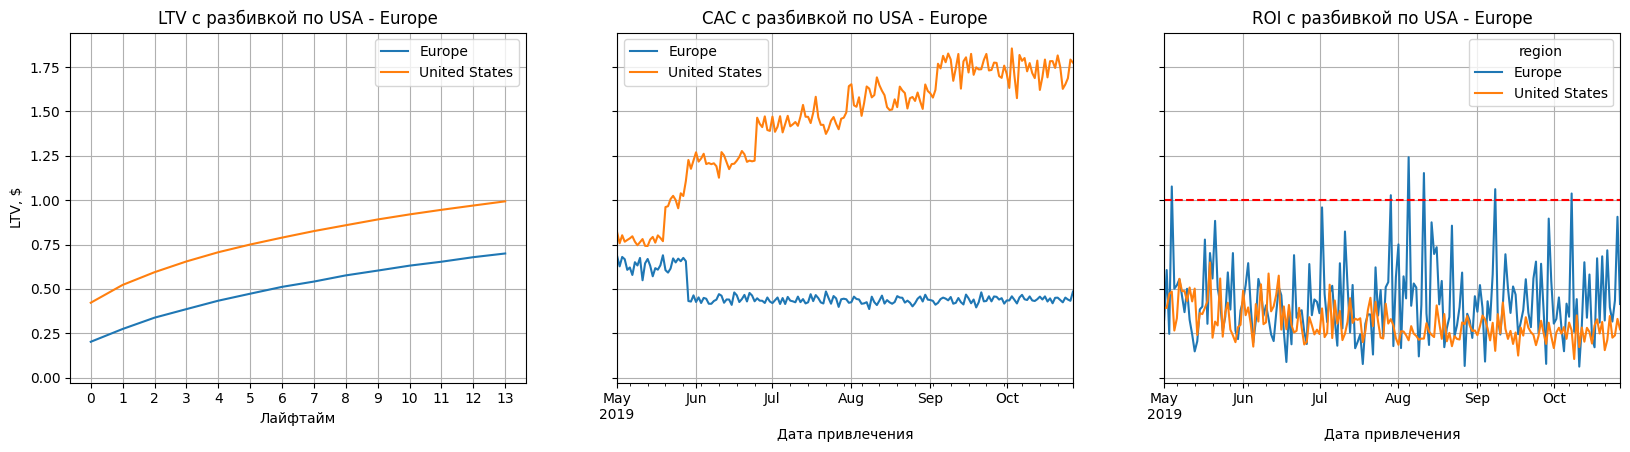

In [269]:
profiles_new = profiles_new.query('channel != "organic"')
ltv_raw, ltv, ltv_history, roi, roi_history = plot_ltv_roi(
    profiles_new, orders, datetime(2019, 11, 11).date(), 14, dimensions=['region']
)

plt.figure(figsize=(20, 10))

ax1=plt.subplot(2, 3, 1)
report = ltv.drop(columns=['cohort_size'])
report.T.plot(grid=True, xticks=list(report.columns.values),ax=ax1)
plt.legend()
plt.title('LTV с разбивкой по USA - Europe')
plt.ylabel('LTV, $')
plt.xlabel('Лайфтайм')


ax2=plt.subplot(2, 3, 2, sharey=ax1)
roi_history.pivot_table(
    index='dt', columns='region', values='cac', aggfunc='mean'
).plot(grid=True,ax=ax2)
plt.legend()
plt.ylabel('CAC, $')
plt.xlabel('Дата привлечения')
plt.title('САС с разбивкой по USA - Europe')


ax3=plt.subplot(2, 3, 3, sharey=ax1)
roi_history.pivot_table(
    index='dt', columns='region', values=0, aggfunc='mean'
).plot(grid=True, ax=ax3)
plt.title('ROI с разбивкой по USA - Europe')
plt.ylabel('ROI')
plt.xlabel('Дата привлечения')
plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
plt.show()


### Вывод
* LTV: как видим, у США прибыль с пользователей приблизительно в 4/3 раза больше, чем у Европы
* CAC: затраты на рекламу заметно отличаются с июня у претендентов: у США наблюдается рост затрат, а у Европы затраты расположены в одних и тех же пределах
* ROI: наблюдаем, что график прибыли  от инвестиций у Европы в большинстве случаев находится над графиком прибыли от инвестиций США; к тому же график Европы местами пересекает уровень окупаемости, а у США - вообще нет

## Общий вывод

* 1.Выделить причины неэффективности привлечения пользователей
* 2.Сформулировать рекомендации для отдела маркетинга

1.
* Страна, в которой не окупаются инвестиции, являются США
* Самые невыгодные устройства: iPhone, Mac
* Самый невыгодный канал : TipTop

* Как видим, все из представленных пунктов взаимосвязаны: основной штаб компании Apple находится в США, также канал TipTop является американским. Одним из основных показателей окупаемости инвестиций являются затраты на рекламу(CAC). У данных претендентов наблюдаются большие траты на продвижение рекламы, но из-за относительно маленькой прибыли с каждого клиента, мы получаем, что окупаемость инвестиций довольно мала.
* Причина неэффективности - неправильное распределение средств на рекламу

2.
* Стоит правильно распределять деньги на рекламу; как видим, самый большой LTV у канала lambdaMediaAds, но на его рекламу уходит "среднее" относительно других каналов средства; думаю, что стоит рассмотреть продвижение данного канала 
* Стоит обратить внимание на "отстающие" устройства : PC, Android. У  PC наблюдаются наименьшая прибыль с пользователей и наименьшие затраты на рекламу, но в то же время самая высокая окупаемость именно у PC. Стоит рассмотреть продвижение рекламы данного устройства
* Стоит обратить внимание на "отстающие" каналы: YRabbit, MediaTornado, LeapBob. На их рекламу идут наименьшие затраты, также прибыль с одного пользователя они также имеют наименьшую